In [1]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import math
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import interp1d
from mplsoccer import VerticalPitch
from highlight_text import HighlightText, ax_text, fig_text
plt.rcParams['figure.figsize'] = [16, 10]
import matplotlib.lines as lines
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
from scipy import ndimage
import matplotlib.patches as patches

In [2]:
df = pd.read_csv(r"C:\Users\limwe\OneDrive\Documents\Computing Projects\Sports Analytics\Visualisations\Data\messi_cleaned.csv")
df.drop('minute',axis=1,inplace=True)

In [3]:
df = df[df['league'] != 'Europe - Champions League']

In [4]:
def create_points(df,bottom,top,left,right,color_dict):
    #takes in the number of values and the necessary dimensions, to create the coordiantes for the waffle and returns a dataframe
    '''
    df: dataframe filtered by season and by situation
    bottom, top,left,right: dimensions of the waffle
    color_dict: color mapping for each shot type 

    returns a dataframe containing - x,y, and corresponding color
    '''

    #get dimensions 
    points =pd.DataFrame()
    count = len(df)
    df = df.groupby('shotType').size().to_frame('size')
    length = math.ceil(right - left +1)
    height = math.ceil(count/length)
    #get coords
    points['x'] = np.tile(np.arange(left,right+1),height)[:count]
    points['y'] = np.repeat(np.arange(top,bottom,-1),length)[:count]
    points = points.sort_values(['x','y'])
    #get colors 
    colors = []
    count_dict = df.to_dict().get('size')
    for key in count_dict:
        colors = colors + [color_dict.get(key)] * count_dict.get(key)
    points['colors'] = colors
    return points

In [5]:
def create_season(df,category,height_dict,height,lower,upper,keys,color_dict):
    '''
    df: dataframe of one season
    category: typically situation 
    height_dict: height to plot each situation at 
    height: max height of each situation 
    lower: first x 
    upper: last x 
    keys: unique category types 

    return dataframe containing x,y, and corresponding colors 
    '''
    points = pd.DataFrame()
    for key in keys: # for each situation type
        ymin = height_dict.get(key)
        ymax = height + ymin
        filtered = df[df[category]==key] #start plotting from the least
        try:
            one = create_points(filtered,ymin,ymax,lower,upper,color_dict)
        except:
            print(filtered,ymin,ymax,lower,upper,color_dict)
            break
        points = pd.concat([points,one])
    return points

In [6]:
def plot_goals(df,gap,height,heights,length,lower,limit,ax,colors):
    """
    df: Dataframe
    gap: gap between seasons
    height = list of heights for each situation
    length: max length per season 
    lower: first x 
    limit: max x
    colors: colors for each type of shot in the order of ['Left Foot', 'Right Foot', 'Head', 'Other']
    """
    seasons = df['season'].unique()
    seasons.sort()

    situations = df['situation'].value_counts(ascending=True).index.tolist()
    height_dict = dict(zip(situations,heights)) #starting height

    types = df['shotType'].value_counts().index.tolist()
    color_dict = dict(zip(types,colors))
    points = pd.DataFrame()
    boundaries = []
    for idx,season in enumerate(seasons):
        season_df = df[df['season'] == season]
        upper = lower + length -1
        one = create_season(season_df,'situation',height_dict,height,lower,upper,situations,color_dict)
        points = pd.concat([one,points])
        lower = points['x'].max() + gap 
        boundaries.append(lower-gap/2)

    #scale 
    xmax = points['x'].max()
    scale = limit/xmax
    points['x'] = points['x'] * scale
    boundaries = [x*scale for x in boundaries]
    ax.scatter(points['x'],points['y'],c=points['colors'],s=8)
    return boundaries,height_dict

In [7]:
def get_circular(min,max,y):
    '''
    min: min x value
    max: max x value 
    y: vertical value
    '''
    x = [min,max]
    y = [y,y]
    points = [x,y]
    x_coord = np.linspace(points[0][0],points[0][1], 500)
    y_coord = interp1d(points[0], points[1])(x_coord)
    return x_coord,y_coord

In [8]:
df['season'].unique()

array(['2020-21', '2019-20', '2018-19', '2017-18', '2016-17', '2015-16',
       '2014-15', '2013-14', '2012-13', '2011-12', '2010-11', '2009-10',
       '2008-09', '2007-08', '2006-07', '2005-06', '2004-05', '2021-22'],
      dtype=object)

In [9]:
def plot_goals_master(sp,fig,max_angle,colors,bg_color,line_color,text_color,font,label_size):
    ax = inset_axes(sp,width=15,height= 15,axes_class = mpl.projections.get_projection_class('polar'),loc= 10)
    ax.set_rorigin(1)
    ax.set_theta_direction(-1)
    ax.set_theta_zero_location('S',offset=20)
    ax.axis('off')
    sp.axis('off')
    fig.patch.set_facecolor(bg_color)
    heights = [0,4,9,16]
    ax.set_ylim(0,36.5)
    sp.set_xlim(0,100)
    sp.set_ylim(0,100)

    #plot the goals 
    boundaries,height_dict = plot_goals(df,gap=4,height=10,heights=heights,length=7,lower=0,limit=max_angle,ax=ax,colors=colors)
    bdor = ['2011-12', '2010-11', '2009-10','2008-09','2014-15','2018-19','2020-21']
    #boundaries 
    seasons = df['season'].unique()
    seasons.sort()
    ax.vlines(boundaries,9,30,colors = line_color,linestyles=':',alpha=0.3)
    for i,line in enumerate(boundaries):
        if seasons[i] in bdor:
            ax.text(boundaries[i],32,seasons[i],color=text_color,ha='center',va='center',fontfamily =font,size=label_size,bbox=dict(facecolor='#FDF09B',alpha=0.55, edgecolor='#FDF09B', boxstyle='round,pad=0.35'))
        else:
            ax.text(boundaries[i],32,seasons[i],color=text_color,ha='center',va='center',fontfamily =font,size=label_size)


    for key in height_dict:
        height = height_dict.get(key) + 11.5
        ax.annotate(key,(max_angle+0.2,height),c=text_color,ha='center',va='center',fontfamily =font,size=label_size,bbox=dict(facecolor=bg_color,edgecolor='none',alpha=1))
        x,y= get_circular(-0.08,max_angle+0.15,height)
        ax.plot(x,y,color = line_color,linestyle='dotted',linewidth=0.5)
    return ax

In [10]:
def plot_shot_end(ax,df,bg_color,colors,line_color,text_color,font,fontsize):
    x = [36,36,44,44]
    y = [0,2.67,2.67,0]
    ax.plot(x,y,c=line_color,linewidth=2)
    cmap = mpl.colors.LinearSegmentedColormap.from_list('',colors)
    #_ = ax.hexbin(df['shotEndY'],df['shotEndZ'],cmap=cmap,gridsize=(30,8))
    _ = ax.hist2d(df['shotEndY'],df['shotEndZ'],cmap=cmap,bins=(10,4))
    ax.set_xlim(35.5,44.5)
    ax.set_ylim(-2,5)
    ax.set_facecolor(bg_color)
    ax.tick_params(axis='both',which='both',bottom=False,left=False,top=False) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    #text
    length = len(df)
    ax.text(40,-1,f'All {length} Goal Ending Locations',ha='center',va='center',color=text_color,size = fontsize,font=font)
    return

In [11]:
def get_legend(ax,colors,font,notes_size,bg_color,text_color,rotation):
    
    table_ax = ax.inset_axes([0.1,0,0.9,1])
    table_ax = draw_table(table_ax,df,notes_size+40,font,colors,bg_color,text_color,rotation)
    # ax.spines.left.set_visible(False)
    # ax.spines.top.set_visible(False)
    # ax.get_xaxis().set_ticks([])
    # ax.get_yaxis().set_ticks([])
    # for spine in ax.spines.values():
    #     spine.set_edgecolor(line_color)
    ax.axis('off')
    ax.set_facecolor(bg_color)
    return ax


In [12]:
def draw_table(ax,df,colors,line_color,text_color,font,font_size,rotation):
    grouped = pd.DataFrame()
    for type in df['shotType'].unique().tolist():
        tmp = df[df['shotType']==type].groupby('situation').size()
        grouped[type] = tmp
    grouped = grouped.fillna(0).astype(int).reindex(['Corner','Penalty','Free Kick','Open Play'])
    rows = grouped.shape[0]
    cols = grouped.shape[1]
    ax.set_ylim(-1, rows + 2)
    ax.set_xlim(0, cols + 1.5)
    
    #plotting  text
    x= 1.5
    for color,(i,col) in zip(colors,enumerate(grouped.columns)):
        for j in range(rows):
            ax.text(x+(0.25*j),(rows-j-1) + (0.7*i),grouped[col].iloc[j],rotation=rotation,ha='center',va='center',color=text_color,font=font,fontsize=font_size)
        ax.text(x-1/8,(rows-0.83)+(0.7*i)+0.5,col,rotation=rotation,ha='center',va='center',color=color,font=font,fontsize=font_size) #col names 
        x+=0.8
    x=0.8
    y=2.35
    for idx in grouped.index:
        ax.text(x,y,idx,rotation=rotation,ha='center',va='center',color=text_color,font=font,fontsize=font_size) #row index name 
        x+=0.25
        y-=1

    #Lines 
    ax.plot((1.23,4.15),(3.18,5.73),color=line_color)
    ax.plot((2.07,5.07),(-0.8,1.83),color=line_color)
    ax.axis('off')
    return ax 


In [13]:
[0.05380212568423238, 0.2959116912632781, 0.56492231968444, 0.8070318852634857, 1.0760425136846477, 1.3450531421058094, 1.6140637705269714, 1.8830743989481333, 2.1520850273692953, 2.421095655790457, 2.690106284211619, 2.9591169126327808, 3.2281275410539427, 3.4971381694751047, 3.7661487978962667, 4.035159426317429, 4.304170054738591, 4.546279620317636][7:9]

[1.8830743989481333, 2.1520850273692953]

In [14]:
(1.8830743989481333+ 2.1520850273692953)/2

2.0175797131587143

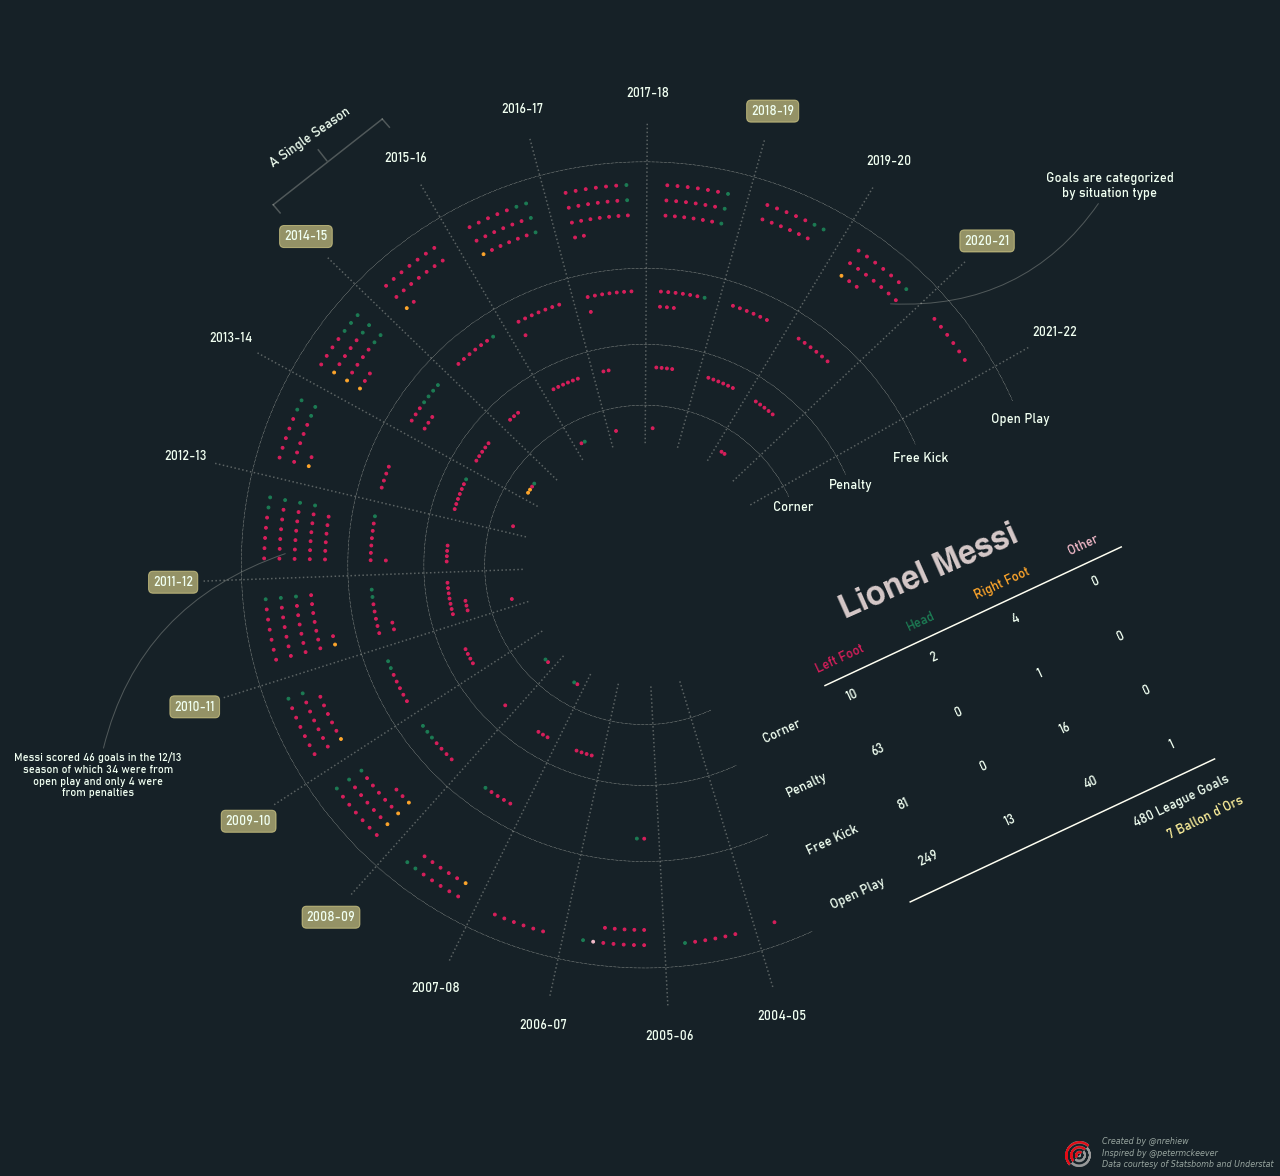

In [17]:

#styles
max_angle = math.pi * 1.43
colors = ['#D81E5B','#1C7C54','#FFA62B','#F2BAC9'] # ['Left Foot', 'Right Foot', 'Head', 'Other']
bg_color = '#162127'
line_color =  '#FFFFF2'
text_color = '#F0FFF1'
font = 'Bahnschrift'
label_size = 13

title_color = '#D6C9C9'
title_size = 32
title_font = 'Helvetica'
subtitle_size = 13
notes_size = 8
rotation = 20
biggest_size = 35


#figure
fig = plt.figure(figsize=(20,16))
ax = fig.subplots()

polar_ax = plot_goals_master(ax,fig,max_angle,colors,bg_color,line_color,text_color,font,label_size)
#Detail
polar_ax.plot((2.690106284211619, 2.9591169126327808),(35,35),color=line_color,linewidth=1.5,alpha=0.25)
polar_ax.plot((2.8246115984221998,2.8246115984221998),(34.8,35.7),color=line_color,linewidth=1.5,alpha=0.25)
polar_ax.plot((2.690106284211619,2.68806284211619),(35,34.3),color=line_color,linewidth=1.5,alpha=0.25)
polar_ax.plot((2.9591169126327808,2.9631169126327808),(35,34.3),color=line_color,linewidth=1.5,alpha=0.25)
polar_ax.text(2.7930115984221998,35.2,"A Single Season",ha='center',font=font,color=text_color,fontsize=subtitle_size,rotation=35)

polar_ax.annotate('Goals are categorized\nby situation type',xy=(max_angle-0.25,24.5),xytext=(max_angle-0.1,40),arrowprops = dict(arrowstyle='-',color=line_color,lw=1,connectionstyle="arc3,rad=-.3",alpha=0.25),ha='center',font=font,color=text_color,fontsize=subtitle_size,)

polar_ax.annotate('Messi scored 46 goals in the 12/13\nseason of which 34 were from\nopen play and only 4 were\nfrom penalties',xy=(1.9530743989481333,24.5),xytext=(1.52,40),arrowprops = dict(arrowstyle='-',color=line_color,lw=1,connectionstyle="arc3,rad=-.3",alpha=0.25),ha='center',font=font,color=text_color,fontsize=subtitle_size-2)
#title
fig.text(0.71,0.457,'Lionel Messi',ha='center',font=title_font,size=title_size,color =title_color,rotation=24,fontweight='bold')
length = len(df)
fig.text(0.92,0.275,f'{length} League Goals',ha='right',font=font,size=subtitle_size,color =text_color,rotation=26)
fig.text(0.93,0.265,'7 Ballon d`Ors',ha='right',font=font,size=subtitle_size,color ='#FDF09B',rotation=26)
fig.text(0.07,0.98,'  ')
# ax_text(2,105,s='<Left Foot> | <Right Foot> | <Head> | <Other>',highlight_textprops=[{'color':colors[0]},{'color':colors[1]},{'color':colors[2]},{'color':colors[3]}],ax=ax,font=font,size=subtitle_size,color =title_color)

#messi image
# messi= plt.imread(r"C:\Users\limwe\OneDrive\Documents\Computing Projects\Sports Analytics\Visualisations\Assets\messi.png")
# messiax = fig.add_axes([0.42,0.42,0.18,0.18], anchor='C', zorder=1,polar=True)
# messiax.imshow(messi)
# messiax.axis('off')


#table
table_ax=ax.inset_axes([0.55,0.1,0.5,0.4375])
# table_ax=ax.inset_axes([0.55,0.05,0.5,0.6])
table_ax = draw_table(table_ax,df,colors,line_color,text_color,font,subtitle_size,25)


#notes
sb = plt.imread(r"C:\Users\limwe\OneDrive\Documents\Computing Projects\Sports Analytics\Data\Logos\SB - Brand Icon - Colour Positive.png")
newax = fig.add_axes([0.80,-0.02,0.022,0.022], anchor='NE', zorder=1)
newax.imshow(sb)
newax.axis('off')
fig.text(0.83,-0.02,'Data courtesy of Statsbomb and Understat',fontsize = notes_size,c=text_color,fontstyle='italic',alpha=0.6)
fig.text(0.83,0,'Created by @nrehiew',fontsize = notes_size,c=text_color,fontstyle='italic',alpha=0.6)
fig.text(0.83,-0.01,'Inspired by @petermckeever',fontsize = notes_size,c=text_color,fontstyle='italic',alpha=0.6)
plt.savefig('messi_polar.jpg',bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none', dpi=300)

In [18]:
df.groupby('season').size()

season
2004-05     1
2005-06     6
2006-07    14
2007-08    10
2008-09    23
2009-10    34
2010-11    31
2011-12    50
2012-13    46
2013-14    28
2014-15    43
2015-16    26
2016-17    37
2017-18    34
2018-19    36
2019-20    25
2020-21    30
2021-22     6
dtype: int64